# Import necessary modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spleaf.rv import Cov
from tools import read_rdb, fit, periodogram, fap

# Load data

In [2]:
rv_data = read_rdb('HD136352_HARPS03.rdb')
epoch_rjd = 55500.0
nt = rv_data['rjd'].size
rv_data['t_d'] = rv_data['rjd'] - epoch_rjd

# Show data

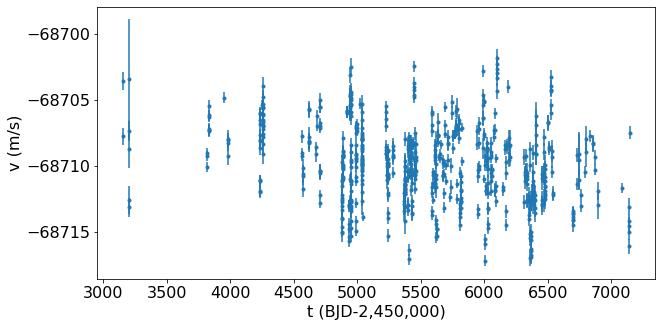

Number of points: 645


In [3]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,5))
plt.errorbar(rv_data['rjd']-5e4, rv_data['vrad'], yerr=rv_data['svrad'], fmt='.', rasterized=True)
plt.xlabel('t (BJD-2,450,000)')
plt.ylabel('v (m/s)')
plt.show()
plt.close()
print('Number of points:', nt)

# Noise model

In [4]:
cov = Cov(rv_data['t_d'], rv_data['ccf_noise']**2 + rv_data['drift_noise']**2,
  var_jitter=0.25,
  calib_file=rv_data['cal_file'], var_calib_meas=rv_data['cal_noise']**2,
  var_calib_inst=np.array([0.25]),
  var_cos_qper=np.array([0.5,0.5]), var_sin_qper=np.zeros(2),
  lambda_qper=np.array([0.1,0.0]), nu_qper=np.array([2*np.pi, 2*np.pi/365.25]))

# Linear part

In [5]:
M0 = np.ones((1,nt)) # offset

# Fit

In [6]:
# Fit offset only
xlin = fit(rv_data['vrad'], cov, [], M0, np.array([0.0]))
# Fit offset + noise parameters
fit(rv_data['vrad'], cov, ['var_jitter', 'var_calib_inst', 'var_cos_qper'], M0, xlin)

array([-68709.57921734])

# Compute periodogram

In [7]:
Pmin = 0.4
Pmax = 10000
nfreq = 200000
nu0 = 2 * np.pi / Pmax
dnu = (2 * np.pi / Pmin - nu0) / (nfreq - 1)
# Compute periodogram
nu, power = periodogram(rv_data['vrad'], cov, M0, nu0, dnu, nfreq)
P = 2 * np.pi / nu
kmax = np.argmax(power)
# Compute FAP
faplvl = fap(power[kmax], cov, M0, nu.max())

# Show periodogram

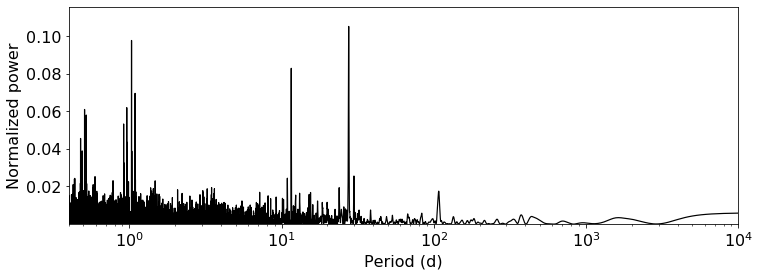

P=27.61573779057252 d, power=0.10514392170257869, FAP=1.1769593682571548e-11


In [8]:
plt.figure(figsize=(12, 4))
plt.plot(P, power, 'k', lw=1.2, rasterized=True)
plt.xlim(Pmin, Pmax)
plt.ylim(power.min(), 1.1 * power.max())
plt.xscale('log')
plt.xlabel('Period (d)')
plt.ylabel('Normalized power')
plt.show()
plt.close()
print('P={} d, power={}, FAP={}'.format(P[kmax], power[kmax], faplvl))